# Small Language Models

This notebook explores several neural network architectures for language modeling tasks. The models are trained on an artificially generated language.

## Background and Motivation
Training language models on real-world language data often requires extensive computational resources typically found in data centers. To explore the fundamental concepts of language modeling in a more accessible manner, we will use an artificially constructed language. This approach allows us to control complexity, understand the underlying mechanics, and ensure resource efficiency.

## Objective
Understand, implement, and compare different neural network architectures (RNN, LSTM, Transformer) in language modeling tasks using an artificially generated language.

## Tasks
1. **Artificial Language Generation for Training**: Generate an initial dataset of sentences using a simple, rule-based grammar (see below).
2. **Tokenization**: Convert these sentences into sequences of integers.
3. **Model Building**: Implement at least the first 3 models - a basic RNN (required), an LSTM (required), 1DCNN (required) and a Transformer (optional)
4. **Training**: Train each model on the artificial language dataset and evaluate the performance of each model while training on the validation set by showing the learning curves for each model and comparing them.

You can use the starter code provided below to get started. Feel free to modify the code as you see fit. The architecture of the models is up to you but can be simple. For example for the RNN it might look like this:

| Layer (type)            | Output Shape      | Param # |
|-------------------------|-------------------|---------|
| embedding_1 (Embedding) | (1, 35, 8)        | 200     |
| simple_rnn (SimpleRNN)  | (1, 50)           | 2,950   |
| dense (Dense)           | (1, 25)           | 1,275   |

Important is to choose an appropriate loss function for the next predicted token. In the above example, the vocabulary size is 25.

In [2]:
import random
# Define the grammar rules
expanded_grammar = {
    'S': [['NP', 'VP'], ['S', 'CONJ', 'S']],
    'NP': [['Det', 'ADJ', 'N'], ['Det', 'N'], ['Det', 'N', 'PP']],
    'VP': [['V', 'NP'], ['V', 'NP', 'PP'], ['V', 'ADV']],
    'PP': [['P', 'NP']],
    'Det': ['a', 'the'],
    'N': ['cat', 'dog', 'bird', 'tree'],
    'V': ['sits', 'runs', 'flies', 'jumps'],
    'ADJ': ['big', 'small', 'quick', 'lazy'],
    'ADV': ['quickly', 'slowly', 'carefully'],
    'P': ['on', 'in', 'under', 'over'],
    'CONJ': ['and', 'but', 'or']
}

def generate_sentence(symbol, depth=0, max_depth=5):
    if depth > max_depth:  # Limiting recursion depth
        return ''

    if symbol not in expanded_grammar:
        return symbol

    expansion = random.choice(expanded_grammar[symbol])
    if isinstance(expansion, list):
        return ' '.join([generate_sentence(sym, depth+1, max_depth) for sym in expansion]).strip()
    else:
        return expansion

### Preprocessing the data (Tokenization and Padding)

In this first step, we will tokenize the data and pad it to the maximum length of the sentences.

In [3]:
random.seed(42) # For reproducibility
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

# Generating a sentences of sentences
num_train = 1000                        # Number of training examples
num_test  = 2000                        # Number of test examples
num_sentences = num_train + num_test    # Number of sentences to generate
sentences = [generate_sentence('S') for _ in range(num_sentences)]

# Creating tokens from sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

# Preparing data for model input
vocab_size = len(tokenizer.word_index) + 1  # Plus 1 for padding

# Pad all sequences to the same length
max_length = max(len(s) for s in sequences)
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')

# Prepare X, y for training
X = sequences[0:num_train,:-1]
y = to_categorical(sequences[0:num_train,-1], num_classes=vocab_size)

X, X_val, y, y_val = train_test_split(X, y, test_size=0.2)

# Prepare X, y for testing
X_test = sequences[num_train:,:-1]
y_test = to_categorical(sequences[num_train:,-1], num_classes=vocab_size)

# The first sentence
print(f"The first sentence :\'{sentences[0]}\'")
print(f"The first sentence after tokanization and padding :\n{sequences[0]}")
print(f"The first sentence X for training (note the last token is missing):\n{X[0]}")
print(f"The first sentence Y for training (note that this is one-hot-encoded):\n{y[0]}")

T = X.shape[1]  # Length of input sequence
V = y.shape[1]  # Vocabolary size
print(f"Shape of X (Batch, T={T}, V={V})")
print(f"Shape of X (in code)): {X.shape}, shape of y: {y.shape}")

The first sentence :'the small dog sits a tree on a small cat'
The first sentence after tokanization and padding :
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  1 17  6 12  2  3 14  2 17  5]
The first sentence X for training (note the last token is missing):
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  6 11  1  3  8  1  5 16
 12 23  8  1  6 11  1 19  3 14  2]
The first sentence Y for training (note that this is one-hot-encoded):
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
Shape of X (Batch, T=35, V=25)
Shape of X (in code)): (800, 35), shape of y: (800, 25)


We have the following shapes

**X**
Note that `X` is a sparse representation in the code. Instead of one-hot-coding the tokens, we are using the token index. This is a more efficient representation of the data, but conceptually it is the same.

**y**
y has the same Batch, Vocabulary. It is the one-hot encoded result of the next token. Note that, here are are using the **last predicted word**. This makes it easier in our code but is less efficient. In technical realizations people also use the word for all $t=1..T$ as the targets.


#### Embedding layer
The first step, we do from $X(B,T,V)$ to $X(B,T,C)$ is the embedding layer. This is a simple matrix multiplication. The size of the embedding layer `C` is a hyperparameter.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, Conv1D, Lambda
from keras.optimizers import Adam

EMB_DIM = 8  # Embedding dimension (a.k.a. C)
emb_model = Sequential()
emb_model.add(Embedding(vocab_size, EMB_DIM))
print(f"Shape {emb_model.predict(X).shape}")

25/25 [==============================] - 0s 1ms/step
Shape (800, 35, 8)


### Further Hints
#### Basic RNN

In the basic RNN model, you can use the `SimpleRNN` layer. The beginning of the code is given below.

In [5]:
# RNN Model
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, EMB_DIM, name="embedding"))           # Embedding layer
rnn_model.add(SimpleRNN(units=50, input_shape=(1, 35, 8), use_bias=True, name="rnn"))
rnn_model.add(Dense(25, activation="softmax", name="output_dense"))

rnn_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

rnn_summary = rnn_model.fit(X, y, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
25/25 [==============================] - 3s 43ms/step - loss: 2.9370 - accuracy: 0.1088 - val_loss: 2.7165 - val_accuracy: 0.0700
Epoch 2/40
25/25 [==============================] - 1s 25ms/step - loss: 2.6487 - accuracy: 0.1262 - val_loss: 2.5636 - val_accuracy: 0.1500
Epoch 3/40
25/25 [==============================] - 1s 39ms/step - loss: 2.5677 - accuracy: 0.1675 - val_loss: 2.5315 - val_accuracy: 0.1850
Epoch 4/40
25/25 [==============================] - 1s 43ms/step - loss: 2.5319 - accuracy: 0.2288 - val_loss: 2.5092 - val_accuracy: 0.2150
Epoch 5/40
25/25 [==============================] - 1s 40ms/step - loss: 2.4753 - accuracy: 0.2400 - val_loss: 2.4242 - val_accuracy: 0.2600
Epoch 6/40
25/25 [==============================] - 1s 25ms/step - loss: 2.3736 - accuracy: 0.2463 - val_loss: 2.2843 - val_accuracy: 0.2050
Epoch 7/40
25/25 [==============================] - 1s 24ms/step - loss: 2.1995 - accuracy: 0.2375 - val_loss: 2.0773 - val_accuracy: 0.2550
Epoch 8/40
25

#### LSTM
Adpot the code from the basic RNN and replace the `SimpleRNN` layer with an `LSTM` layer.

In [10]:
# LSTM Model
LSTM_model = Sequential()
LSTM_model.add(Embedding(vocab_size, EMB_DIM, input_length=35, name="embedding"))           # Embedding layer
LSTM_model.add(LSTM(25, activation="tanh", name="lstm"))
LSTM_model.add(Dense(25, activation="softmax", name="output_dense"))

LSTM_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

LSTM_summary = LSTM_model.fit(X, y, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
25/25 [==============================] - 3s 25ms/step - loss: 3.1723 - accuracy: 0.1075 - val_loss: 3.0749 - val_accuracy: 0.1200
Epoch 2/40
25/25 [==============================] - 0s 11ms/step - loss: 2.7962 - accuracy: 0.1213 - val_loss: 2.6831 - val_accuracy: 0.1200
Epoch 3/40
25/25 [==============================] - 0s 6ms/step - loss: 2.6154 - accuracy: 0.1225 - val_loss: 2.5866 - val_accuracy: 0.1500
Epoch 4/40
25/25 [==============================] - 0s 7ms/step - loss: 2.5752 - accuracy: 0.1312 - val_loss: 2.5535 - val_accuracy: 0.1500
Epoch 5/40
25/25 [==============================] - 0s 7ms/step - loss: 2.5594 - accuracy: 0.1775 - val_loss: 2.5475 - val_accuracy: 0.1500
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 2.5445 - accuracy: 0.1312 - val_loss: 2.5231 - val_accuracy: 0.1500
Epoch 7/40
25/25 [==============================] - 0s 7ms/step - loss: 2.5291 - accuracy: 0.1762 - val_loss: 2.5150 - val_accuracy: 0.1750
Epoch 8/40
25/25 [


#### 1DCNN
Start same as LSTM and RNN. Replace the `LSTM` layer with serval `Conv1D` layer as shown in the lecture slides. The last layer should only return a single value. This can be achived with
```python
cnn_model.add(Lambda(lambda x: x[:, -1, :]))
```

In [7]:
# RNN Model
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, EMB_DIM, name="embedding"))           # Embedding layer
cnn_model.add(Conv1D(filters=32, kernel_size=2, padding="causal", dilation_rate=1))
cnn_model.add(Conv1D(filters=32, kernel_size=2, padding="causal", dilation_rate=2))
cnn_model.add(Conv1D(filters=32, kernel_size=2, padding="causal", dilation_rate=4))
cnn_model.add(Conv1D(filters=32, kernel_size=2, padding="causal", dilation_rate=8))
cnn_model.add(Dense(25, activation="softmax"))
cnn_model.add(Lambda(lambda x: x[:, -1, :]))

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_summary = cnn_model.fit(X, y, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
25/25 [==============================] - 9s 40ms/step - loss: 3.0690 - accuracy: 0.0988 - val_loss: 2.7922 - val_accuracy: 0.0800
Epoch 2/40
25/25 [==============================] - 0s 6ms/step - loss: 2.6458 - accuracy: 0.1125 - val_loss: 2.5644 - val_accuracy: 0.1650
Epoch 3/40
25/25 [==============================] - 0s 7ms/step - loss: 2.4919 - accuracy: 0.1813 - val_loss: 2.4009 - val_accuracy: 0.2350
Epoch 4/40
25/25 [==============================] - 0s 7ms/step - loss: 2.2821 - accuracy: 0.2450 - val_loss: 2.1156 - val_accuracy: 0.2350
Epoch 5/40
25/25 [==============================] - 0s 7ms/step - loss: 1.8606 - accuracy: 0.2537 - val_loss: 1.7558 - val_accuracy: 0.2550
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 1.6333 - accuracy: 0.2763 - val_loss: 1.6036 - val_accuracy: 0.2950
Epoch 7/40
25/25 [==============================] - 0s 7ms/step - loss: 1.5208 - accuracy: 0.2975 - val_loss: 1.5434 - val_accuracy: 0.2550
Epoch 8/40
25/25 [=

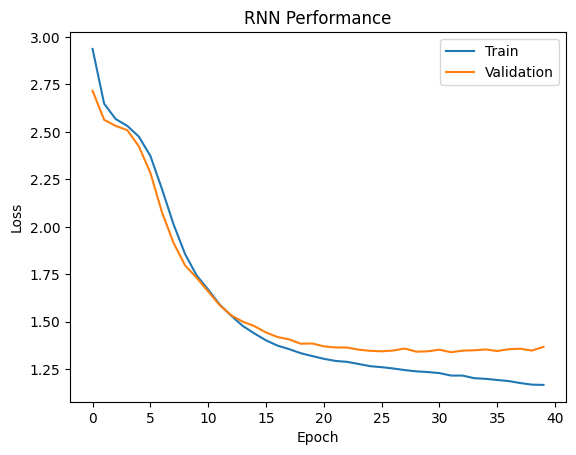

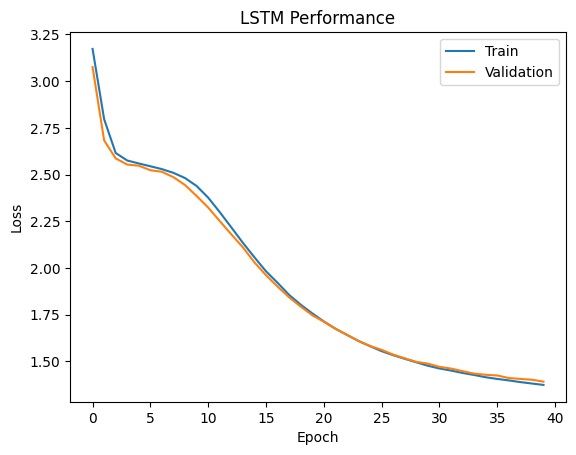

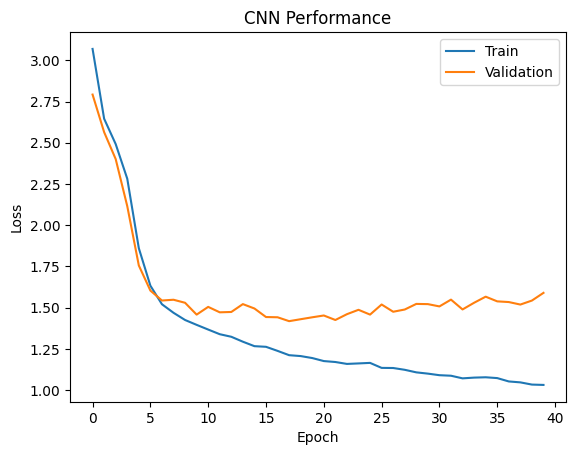

In [11]:
import matplotlib.pyplot as plt

## Visualize
plt.plot(rnn_summary.history['loss'], label='Train')
plt.plot(rnn_summary.history['val_loss'], label='Validation')
plt.title('RNN Performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(LSTM_summary.history['loss'], label='Train')
plt.plot(LSTM_summary.history['val_loss'], label='Validation')
plt.title('LSTM Performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



plt.plot(cnn_summary.history['loss'], label='Train')
plt.plot(cnn_summary.history['val_loss'], label='Validation')
plt.title('CNN Performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()